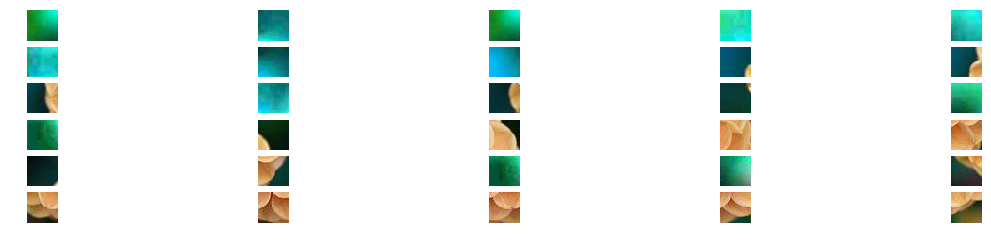

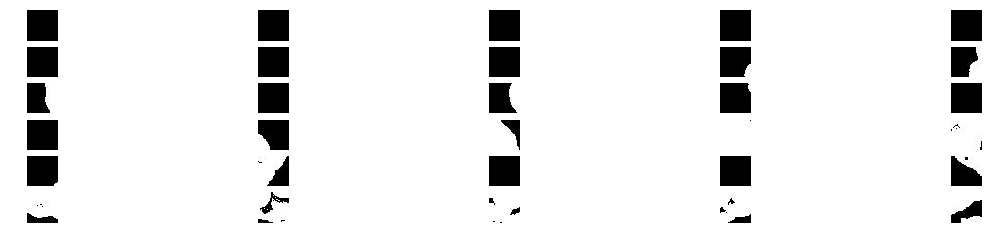

In [10]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
from PIL import Image
import os, os.path, time

# read positive and negative training images

Images = np.zeros((38,32,32,3),dtype=np.float32)
Labels = np.zeros((38,32,32),dtype=np.float32)
cnt=0
folderImages = "TrainingImages"
folderLabels = "TrainingLabels"
for file in os.listdir(folderImages):
    if file.endswith(".jpg"):
        im = np.array(Image.open(os.path.join(folderImages,file)))/255.0
        Images[cnt,:,:,:] = im
        lb = np.array(Image.open(os.path.join(folderLabels,file)))/255.0
        Labels[cnt,:,:] = lb
        cnt = cnt + 1
        
%matplotlib inline
plt.figure(figsize=(20,20))
for iteration in range(30):
    plt.subplot(30, 5, iteration + 1)
    plt.imshow(Images[iteration,:,:,:])
    plt.axis("off")
plt.figure(figsize=(20,20))
for iteration in range(30):
    plt.subplot(30, 5, iteration + 1)
    plt.imshow(Labels[iteration,:,:],cmap="gray")
    plt.axis("off")

In [16]:
X = tf.placeholder(tf.float32,shape=(None,None,None,3),name="X")
#X = tf.placeholder(tf.float32,shape=(None,32,32,3),name="X")
y = tf.placeholder(tf.float32,shape=(None,32,32,2),name="y")

with tf.name_scope("dnn"):
    # conv layer 1
    conv1 = tf.layers.conv2d(inputs=X,filters=2,
                         kernel_size=[3, 3],padding="valid",activation=tf.nn.relu)
    print("conv1",conv1.shape)
    
    # maxpool layer 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    print("pool1",pool1.shape)
    
    # Convolutional Layer #2 
    conv2 = tf.layers.conv2d(inputs=pool1,filters=4,kernel_size=[3, 3],
                          padding="valid",activation=tf.nn.relu)
    print("conv2",conv2.shape)

    # Pooling Layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    print("pool2",pool2.shape)

    # Conv transpose (aka deconvolution)
    upsampling1 = tf.layers.conv2d_transpose(inputs=pool2,filters=2,kernel_size=[5, 5],
                          strides=2, padding="valid",activation=tf.nn.relu)
    print("Upsampling1",upsampling1.shape)
    
    # second conv transpose (aka deconvolution)
    upsampling2 = tf.layers.conv2d_transpose(inputs=tf.add(upsampling1,pool1),filters=2,kernel_size=[4, 4],
                          strides=2, padding="valid",activation=tf.nn.relu)
    print("Upsampling2",upsampling2.shape)
    
with tf.name_scope("probability_and_loss"):
    yp    = tf.nn.softmax(upsampling2)
    print("predticted y",yp.shape)
    #loss = -tf.reduce_mean(y*tf.log(yp))
    loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=upsampling2)
    print("loss",loss.shape)

conv1 (?, ?, ?, 2)
pool1 (?, ?, ?, 2)
conv2 (?, ?, ?, 4)
pool2 (?, ?, ?, 4)
Upsampling1 (?, ?, ?, 2)
Upsampling2 (?, ?, ?, 2)
predticted y (?, ?, ?, 2)
loss ()


In [17]:
# Now train the convnet for classifying images
learning_rate = 0.005
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    accuracy = 100.0*tf.reduce_mean(tf.cast(tf.equal(tf.argmax(upsampling2,axis=-1),tf.argmax(y,axis=-1)),tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 500

one_hot_labels = np.zeros((38,32,32,2),dtype=np.float32)
one_hot_labels[:,:,:,0] = Labels
one_hot_labels[:,:,:,1] = 1.0-Labels

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        sess.run(training_op, feed_dict={X:Images, y:one_hot_labels})
        if epoch%100==0:
            acc_train       = accuracy.eval(feed_dict={X:Images, y:one_hot_labels})
            print(epoch,"Training accuracy:",acc_train)
    save_path = saver.save(sess,"./my_model2_final.ckpt")

0 Training accuracy: 71.4047
100 Training accuracy: 71.4792
200 Training accuracy: 94.2331
300 Training accuracy: 95.4281
400 Training accuracy: 95.8984


INFO:tensorflow:Restoring parameters from ./my_model2_final.ckpt
Training accuracy: 96.3199
flower image shape (427, 640, 3)
segmented image shape (1, 428, 640, 2)


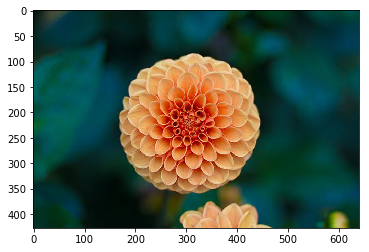

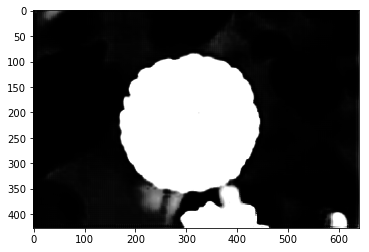

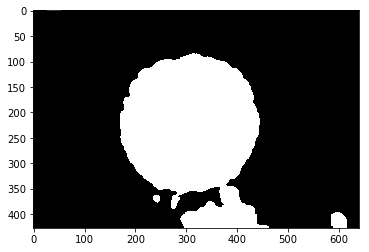

In [21]:
from scipy.misc import imresize

flower = np.array(Image.open("flower.jpg"))/255.0
h,w,c = flower.shape
im = np.zeros((1,h+1,w,c),dtype=np.float32)
im[0,0:h,:,:] = flower

# Restore model
with tf.Session() as sess:
    saver.restore(sess,"./my_model2_final.ckpt")
    acc_train       = accuracy.eval(feed_dict={X:Images, y:one_hot_labels})
    print("Training accuracy:",acc_train)
    segmentation = yp.eval(feed_dict={X:im})

print("flower image shape",flower.shape)
print("segmented image shape",segmentation.shape)

resized_seg = np.array(imresize(segmentation[0,:,:,0],[h,w]),dtype=np.float32)/255.0
plt.imshow(flower)
plt.show()
plt.imshow(resized_seg,cmap="gray")
plt.show()
plt.imshow(resized_seg>0.5,cmap="gray")
plt.show()